In [38]:
import time
import numpy as np
import torch 
import cv2
import os
import uuid 
import path
import pydot
from typing import List, Tuple
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image
import pathlib
import shutil
from mtcnn import MTCNN
from tensorflow.keras.layers import Layer
import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Loss
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
import scipy.misc
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [39]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [40]:
#setting up the Path 
POS_PATH='/Users/siddharth/Siamesedata/positive'
NEG_PATH='/Users/siddharth/Siamesedata/negative'
ANC_PATH='/Users/siddharth/Siamesedata/anchor'

In [41]:
#seting up directories 
os.makedirs(POS_PATH,exist_ok= True)
os.makedirs(NEG_PATH,exist_ok= True)
os.makedirs(ANC_PATH,exist_ok= True)

In [42]:
# Import uuid library to generate unique image names
import uuid
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
     # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()
    

In [43]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [44]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg')
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg')
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg')

In [45]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)
samples = data.as_numpy_iterator()
example = samples.next()
example

(b'/Users/siddharth/Siamesedata/anchor/Jack_Straw_0019.jpg',
 b'/Users/siddharth/Siamesedata/positive/Thad_Matta_0001.jpg',
 1.0)

In [46]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)


# Data Pipeline 

In [47]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)


# ResNet50 (generates 512 embedding of images) 

In [48]:

from typing import Tuple
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    BatchNormalization,
    Activation,
    MaxPooling2D,
    ZeroPadding2D,
    Add,
    AveragePooling2D,
    Flatten,
    Dense,
)
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model


def identity_block(X, level, block, filters):
    """
    Implementation of the identity block as defined in the ResNet model.

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    level -- level/layer of the block (used for naming)
    block -- block identifier (used for naming)
    filters -- python list of integers, defining the number of filters in the CONV layers

    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve filters
    f1, f2, f3 = filters

    # Define names for the layers using the provided level and block numbers
    conv_name = 'res' + str(level) + '_' + str(block) + '_{}_{}'

    # Save the input value to be used in the skip connection
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=f1, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name.format(1, 'conv'), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(1, 'bn'))(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1), padding='same',
               name=conv_name.format(2, 'conv'), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(2, 'bn'))(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name.format(3, 'conv'), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(3, 'bn'))(X)

    # Add shortcut value to main path and pass it through a ReLU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def convolutional_block(X, level, block, filters, s=2):
    """
    Implementation of the convolutional block as defined in the ResNet model.

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    level -- level/layer of the block (used for naming)
    block -- block identifier (used for naming)
    filters -- python list of integers, defining the number of filters in the CONV layers
    s -- stride for the first convolutional layer in the block

    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve filters
    f1, f2, f3 = filters

    # Define names for the layers using the provided level and block numbers
    conv_name = 'res' + str(level) + '_' + str(block) + '_{}_{}'

    # Save the input value to be used in the skip connection
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=f1, kernel_size=(1, 1), strides=(s, s), padding='valid',
               name=conv_name.format(1, 'conv'), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(1, 'bn'))(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1), padding='same',
               name=conv_name.format(2, 'conv'), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(2, 'bn'))(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name.format(3, 'conv'), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(3, 'bn'))(X)

    # Shortcut path
    X_shortcut = Conv2D(filters=f3, kernel_size=(1, 1), strides=(s, s), padding='valid',
                        name=conv_name.format('shortcut', 'conv'), kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=conv_name.format('shortcut', 'bn'))(X_shortcut)

    # Add shortcut value to main path and pass it through a ReLU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def ResNet50(input_size: Tuple[int, int, int], embedding_size: int) -> Model:
    """
    Implementation of the ResNet50 architecture.

    Arguments:
    input_size -- shape of the input images (height, width, channels)
    embedding_size -- size of the embedding vector

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input placeholder as a tensor with shape input_size
    X_input = Input(input_size)

    # Zero-padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, level=2, block=1, filters=[64, 64, 256], s=1)
    X = identity_block(X, level=2, block=2, filters=[64, 64, 256])
    X = identity_block(X, level=2, block=3, filters=[64, 64, 256])

    # Stage 3
    X = convolutional_block(X, level=3, block=1, filters=[128, 128, 512], s=2)
    X = identity_block(X, level=3, block=2, filters=[128, 128, 512])
    X = identity_block(X, level=3, block=3, filters=[128, 128, 512])
    X = identity_block(X, level=3, block=4, filters=[128, 128, 512])

    # Stage 4
    X = convolutional_block(X, level=4, block=1, filters=[256, 256, 1024], s=2)
    X = identity_block(X, level=4, block=2, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=3, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=4, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=5, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=6, filters=[256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, level=5, block=1, filters=[512, 512, 2048], s=2)
    X = identity_block(X, level=5, block=2, filters=[512, 512, 2048])
    X = identity_block(X, level=5, block=3, filters=[512, 512, 2048])

    # Average pooling
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # Flatten the output
    X = Flatten()(X)

    # Fully connected layer
    X = Dense(embedding_size, activation='linear', name='fc' + str(embedding_size),
              kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model instance
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model


# Create ResNet50 model for input images of size 100x100 and embedding size of 128
input_size = (100, 100, 3)
embedding_size = 512
model = ResNet50(input_size, embedding_size)


# Siamese Model 

In [49]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [50]:
l1 = L1Dist()

In [51]:
def make_siamese_model():
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100, 100, 3))

    # Get embeddings using your ResNet model
    inp_embedding = model(input_image)
    val_embedding = model(validation_image)

    # Siamese L1 Distance class
    class L1Dist(Layer):
        def __init__(self, **kwargs):
            super().__init__()

        def call(self, input_embedding, validation_embedding):
            return tf.math.abs(input_embedding - validation_embedding)

    l1 = L1Dist()
    distances = l1(inp_embedding, val_embedding)

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')



In [52]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 ResNet50 (Functional)       (None, 512)                  2463680   ['input_img[0][0]',           
                                                          0          'validation_img[0][0]']      
                                                                                     

In [53]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [54]:
checkpoint_dir = '/Users/siddharth/Siamesedata/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)


In [55]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1.],
      dtype=float32)

In [56]:
tf.losses.BinaryCrossentropy??

# Training the model 

In [57]:
def calculate_far_frr(y_true, y_pred):
    # Convert the predictions to binary (0 or 1) based on a threshold of 0.5
    y_pred_binary = tf.where(y_pred >= 0.5, 1.0, 0.0)

    # Calculate the confusion matrix
    tp = tf.reduce_sum(tf.multiply(y_true, y_pred_binary))
    tn = tf.reduce_sum(tf.multiply(1 - y_true, 1 - y_pred_binary))
    fp = tf.reduce_sum(tf.multiply(1 - y_true, y_pred_binary))
    fn = tf.reduce_sum(tf.multiply(y_true, 1 - y_pred_binary))

    # Calculate FAR and FRR
    far = fp / (fp + tn)
    frr = fn / (fn + tp)

    return far, frr

In [58]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [59]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall


In [60]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

# Define the training function
def train(data, EPOCHS):
    # Check if there is a previous checkpoint to resume training
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        checkpoint.restore(latest_checkpoint)
        print(f"Resuming training from checkpoint: {latest_checkpoint}")

    # Create a checkpoint manager
    checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

    # Initialize lists to store loss and metrics values after each epoch
    loss_values = []
    recall_values = []
    precision_values = []
    far_values = []
    frr_values = []

    # Loop through epochs
    for epoch in range(1, EPOCHS + 1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        epoch_loss = 0.0

        # Creating a metric object
        r = tf.keras.metrics.Recall()
        p = tf.keras.metrics.Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here and accumulate the loss
            loss = train_step(batch)
            epoch_loss += loss

            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx + 1)

        # Calculate the average loss for the epoch
        avg_loss = epoch_loss / len(data)

        # Calculate FAR and FRR for the current epoch
        y_true = np.concatenate([batch[2] for batch in data], axis=0)
        y_pred = np.concatenate([siamese_model.predict(batch[:2]) for batch in data], axis=0)
        far, frr = calculate_far_frr(y_true, y_pred)

        # Append metrics to lists
        loss_values.append(avg_loss.numpy())
        recall_values.append(r.result().numpy())
        precision_values.append(p.result().numpy())
        far_values.append(far)
        frr_values.append(frr)

        # Print metrics for the epoch
        print(f"Avg. Loss: {avg_loss.numpy()}, Recall: {r.result().numpy()}, Precision: {p.result().numpy()}, FAR: {far}, FRR: {frr}")

        # Save the checkpoint
        checkpoint_manager.save()

        # Save loss values to a CSV file after each epoch
        with open('loss_values.csv', 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(loss_values)

    # Plot the loss graph after all epochs
    plt.figure()
    plt.plot(loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Graph')
    plt.show()


# Saving the model 

In [61]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})


In [62]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall


In [63]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

1/1 [==============================] - 1s 688ms/step


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [64]:
# Convert y_hat probabilities to binary predictions using a threshold of 0.5
y_pred_binary = [1 if prediction > 0.5 else 0 for prediction in y_hat]

# Calculate the number of genuine samples (true label = 1) and impostor samples (true label = 0)
num_genuine = sum(y_true)
num_impostor = len(y_true) - num_genuine

# Initialize variables to count false acceptance and false rejection
false_acceptance = 0
false_rejection = 0

# Loop through the predictions and compare with true labels to calculate FAR and FRR
for y_true_val, y_pred_val in zip(y_true, y_pred_binary):
    if y_true_val == 1 and y_pred_val == 0:
        false_rejection += 1
    elif y_true_val == 0 and y_pred_val == 1:
        false_acceptance += 1

# Calculate FAR and FRR as ratios
far = false_acceptance / num_genuine
frr = false_rejection / num_impostor

print("False Acceptance Rate (FAR): {:.2%}".format(far))
print("False Rejection Rate (FRR): {:.2%}".format(frr))


False Acceptance Rate (FAR): 128.57%
False Rejection Rate (FRR): 0.00%


In [65]:
y_true

array([0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1.],
      dtype=float32)

In [66]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [67]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.4375

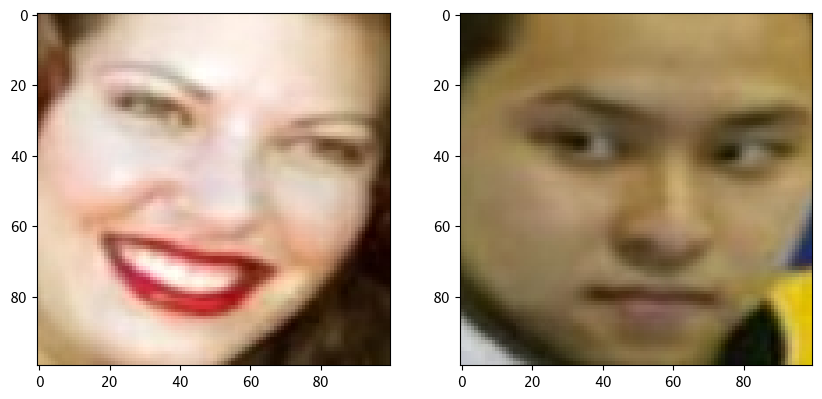

In [68]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# Take Image of person You need to verify 

In [71]:
import cv2
from mtcnn import MTCNN
from PIL import Image

def capture_and_process_face(save_folder):
    # Initialize the camera capture
    cap = cv2.VideoCapture(0)

    # Initialize the MTCNN detector
    detector = MTCNN()

    while True:
        # Capture frame-by-frame from the camera
        ret, frame = cap.read()

        # Detect faces in the frame using MTCNN
        faces = detector.detect_faces(frame)

        for idx, face_info in enumerate(faces):
            # Extract the face bounding box coordinates
            x, y, width, height = face_info['box']

            # Draw a rectangle around the detected face on the frame
            cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0), 2)

        # Display the original frame with the detected faces
        cv2.imshow('Camera', frame)

        # Check for user input to capture the image (press 'c')
        key = cv2.waitKey(1) & 0xFF
        if key == ord('c'):
            # Save the first detected face (assuming there's only one face in the frame)
            if len(faces) > 0:
                x, y, width, height = faces[0]['box']
                face = frame[y:y+height, x:x+width]
                face_resized = cv2.resize(face, (100, 100))
                save_path = f"{save_folder}/face_0.jpg"
                cv2.imwrite(save_path, face_resized)
                print("Face captured and saved!")
            else:
                print("No face detected!")

        # Press 'q' to exit the loop
        elif key == ord('q'):
            break

    # Release the camera and close the window
    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    # Specify the folder to save the cropped and resized face images
    save_faces_folder = "/Users/siddharth/Siamesedata/application_data/verification_images"

    # Call the function to capture from the camera and process faces
    capture_and_process_face(save_faces_folder)


1/1 [==============================] - 0s 9ms/step


# Prediction 

In [69]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 216ms/step


array([[0.5398537 ],
       [0.5194396 ],
       [0.50459874],
       [0.50779414],
       [0.5062624 ],
       [0.5020199 ],
       [0.51983887],
       [0.50552255],
       [0.54296476],
       [0.50094193],
       [0.5146872 ],
       [0.51106304],
       [0.5027194 ],
       [0.5016034 ],
       [0.50429434],
       [0.5320808 ]], dtype=float32)

In [70]:
import cv2
import mtcnn
import os
import numpy as np
import tensorflow as tf

# Load the Siamese model
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

# Load the pre-trained MTCNN face detection model
face_detector = mtcnn.MTCNN()

def preprocess_image(image):
    # Resize the image to the required input size of the Siamese model
    image = cv2.resize(image, (100, 100))
    # Convert image to float and normalize to [0, 1]
    image = image.astype(np.float32) / 255.0
    # Expand dimensions to make it a batch of 1
    image = np.expand_dims(image, axis=0)
    return image

def verify_face(image1, image2):
    # Preprocess both images
    image1 = preprocess_image(image1)
    image2 = preprocess_image(image2)

    # Use the Siamese model to get the similarity score
    similarity_score = siamese_model.predict([image1, image2])[0][0]

    return similarity_score

def real_time_facial_verification():
    # Path to the folder with correct images
    verification_images_folder = '/Users/siddharth/Siamesedata/application_data/verification_images'
    correct_images = []

    # Load the correct images from the folder
    for file in os.listdir(verification_images_folder):
        image_path = os.path.join(verification_images_folder, file)
        img = cv2.imread(image_path)
        if img is not None:
            correct_images.append(img)

    # Open the webcam
    cap = cv2.VideoCapture(0)

    while True:
        # Read a frame from the webcam
        ret, frame = cap.read()

        # Detect faces in the frame using MTCNN
        faces = face_detector.detect_faces(frame)

        for face in faces:
            # Extract the bounding box coordinates for the face
            x, y, width, height = face['box']
            x2, y2 = x + width, y + height

            # Crop the face region from the frame
            face_region = frame[y:y2, x:x2]

            # Perform verification on each correct image
            verified = False
            for reference_face in correct_images:
                similarity_score = verify_face(face_region, reference_face)
                if similarity_score >= 0.5:  # You can adjust the threshold as needed
                    verified = True
                    break

            # Draw the bounding box around the face
            if verified:
                cv2.putText(frame, 'Verified', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            else:
                cv2.putText(frame, 'Unknown', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            cv2.rectangle(frame, (x, y), (x2, y2), (0, 255, 0), 2)

        # Display the frame
        cv2.imshow('Facial Verification', frame)

        # Exit the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video capture and close the OpenCV windows
    cap.release()
    cv2.destroyAllWindows()

if __name__ == '__main__':
    real_time_facial_verification()


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 27ms/step


# Input First image for recognition 